In [ ]:
!pip install opencv-python matplotlib

In [1]:
# Cell 1: Installations and Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("Libraries imported successfully!")

2025-10-18 06:53:50.120316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 06:53:50.129749: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 06:53:50.524659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-18 06:53:52.660290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Libraries imported successfully!


In [2]:
# Cell 2: Configuration and Setup
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
EPOCHS = 30  # Reduced for faster experimentation
NUM_CLASSES = 7
#IMG_SIZE = (224, 224)
# Emotion labels
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print("Configuration set!")

Configuration set!


In [11]:
# Cell 3: Data Preparation Function
def create_data_generators(data_path='train_dir'):
    """
    Create data generators for training and validation
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='grayscale',
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    print(f"Classes: {train_generator.class_indices}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")

    return train_generator, val_generator

# Test data loading
try:
    train_gen, val_gen = create_data_generators()
    print("Data generators created successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure the dataset path is correct!")

Found 22247 images belonging to 7 classes.
Found 5558 images belonging to 7 classes.
Classes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22247
Validation samples: 5558
Data generators created successfully!


In [4]:
# Limpieza exhaustiva del dataset
import os
from PIL import Image
from pathlib import Path

def clean_dataset_exhaustive(data_path='train_dir'):
    """
    Limpia el dataset de archivos corruptos de manera exhaustiva.
    """
    data_path = Path(data_path)
    if not data_path.exists():
        print(f"La ruta {data_path} no existe.")
        return

    for emotion_dir in data_path.iterdir():
        if emotion_dir.is_dir():
            print(f"Revisando {emotion_dir}...")
            for img_file in emotion_dir.glob('*'):
                try:
                    with Image.open(img_file) as img:
                        img.verify()  # Verificar integridad
                    # También intentamos convertir a RGB para asegurar
                    with Image.open(img_file) as img:
                        img.convert('RGB')
                except (IOError, SyntaxError, Exception) as e:
                    print(f"Eliminando archivo corrupto: {img_file} - Error: {e}")
                    os.remove(img_file)

clean_dataset_exhaustive()

Revisando train_dir/happy...
Revisando train_dir/sad...
Revisando train_dir/fear...
Revisando train_dir/neutral...
Revisando train_dir/surprise...
Revisando train_dir/disgust...
Revisando train_dir/angry...


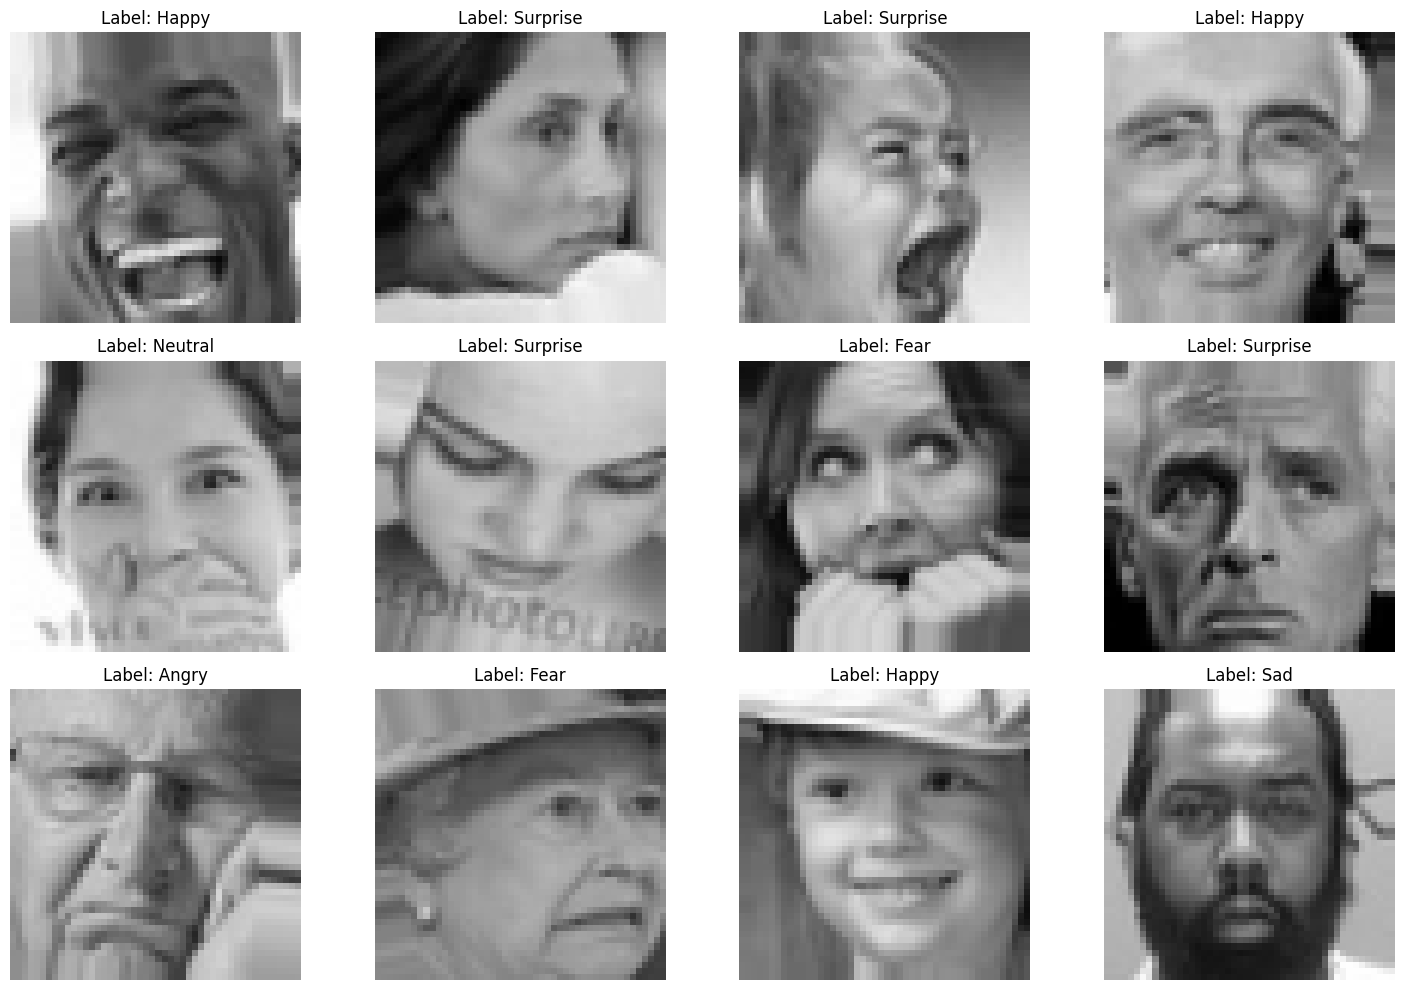

In [5]:
# Cell 4: Visualize Sample Images
def visualize_samples(generator, num_samples=12):
    """
    Visualize sample images from the generator
    """
    plt.figure(figsize=(15, 10))
    images, labels = next(generator)
    
    for i in range(min(num_samples, len(images))):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {EMOTIONS[np.argmax(labels[i])]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
if 'train_gen' in locals():
    visualize_samples(train_gen)

In [6]:
# Cell 5: Model from Scratch
def create_cnn_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

# Create and display model summary
cnn_model = create_cnn_model()
cnn_model.summary()

/home/david/Documentos/estudios/2025-2 ITM/EII/venv-eii/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-18 06:54:27.574748: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,983 (2.01 MB)

 Trainable params: 524,999 (2.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
# Cell 6: Transfer Learning Model
def create_transfer_model():
    # Capa de entrada para imágenes en escala de grises
    input_layer = layers.Input(shape=(48, 48, 1))
    
    # Convertir a 3 canales repitiendo los valores
    x = layers.Conv2D(3, (1, 1), padding='same', activation='linear')(input_layer)
    # También podríamos usar una capa Lambda: x = layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(input_layer)

    # Cargar VGG16 sin especificar input_tensor, sino que usamos el tensor x como entrada
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(48, 48, 3)   # Ahora especificamos la forma de entrada esperada
    )
    
    # Congelar capas base
    base_model.trainable = False
    
    # Pasar el tensor x por el base_model
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs)
    
    return model

transfer_model = create_transfer_model()
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,845 (56.64 MB)

 Trainable params: 133,645 (522.05 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [14]:
# Cell 7 CORREGIDA: Fine-Tuning Model (Solución Funcional)
def create_fine_tuned_model():
    """
    Modelo de Fine-Tuning corregido - Usando API Funcional correctamente
    """
    # Capa de entrada
    input_layer = layers.Input(shape=(48, 48, 1), name='fine_tune_input')
    
    # Convertir grayscale a RGB usando Lambda (más estable)
    x = layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1), name='to_rgb')(input_layer)
    
    # Cargar VGG16 con input_shape
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(48, 48, 3)  # Usar input_shape, NO input_tensor
    )
    
    # Fine-tuning: descongelar últimas capas
    base_model.trainable = True
    
    # Congelar la mayoría de las capas, descongelar solo las últimas
    # VGG16 tiene 19 capas, descongelamos las últimas 4-6
    for layer in base_model.layers[:-6]:
        layer.trainable = False
    
    # Conectar el base_model
    x = base_model(x, training=False)  # training=False para batch norm congelado
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)
    x = layers.Dense(256, activation='relu', name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=input_layer, outputs=outputs, name='vgg16_fine_tuned')
    
    return model

# Crear modelo
try:
    fine_tuned_model = create_fine_tuned_model()
    print("✅ Modelo Fine-Tuned creado correctamente")
    fine_tuned_model.summary()
    
    # Mostrar capas entrenables
    trainable_count = sum([layer.trainable for layer in fine_tuned_model.layers[2].layers])  # Capas de VGG16
    total_count = len(fine_tuned_model.layers[2].layers)
    print(f"Capas de VGG16 entrenables: {trainable_count}/{total_count}")
    
except Exception as e:
    print(f"❌ Error: {e}")

✅ Modelo Fine-Tuned creado correctamente


Model: "vgg16_fine_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fine_tune_input (InputLayer)    │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ to_rgb (Lambda)                 │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,839 (56.64 MB)

 Trainable params: 9,572,871 (36.52 MB)

 Non-trainable params: 5,275,968 (20.13 MB)

Capas de VGG16 entrenables: 6/19


In [9]:
# Cell 8: Training Function
def train_model(model, train_gen, val_gen, model_name, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        EarlyStopping(patience=10, restore_best_weights=True)
    ]
    
    print(f"Training {model_name}...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )
    
    model.save(f'{model_name}_emotion.h5')
    print(f"Model {model_name} saved!")
    
    return history

def plot_training_history(history, model_name):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

Training cnn_scratch...
Epoch 1/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 70s 95ms/step - accuracy: 0.2561 - loss: 2.1554 - val_accuracy: 0.3181 - val_loss: 1.9140 - learning_rate: 0.0010
Epoch 2/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.3881 - loss: 1.6392 - val_accuracy: 0.3566 - val_loss: 1.7126 - learning_rate: 0.0010
Epoch 3/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.4515 - loss: 1.4511 - val_accuracy: 0.2643 - val_loss: 2.1409 - learning_rate: 0.0010
Epoch 4/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.4893 - loss: 1.3555 - val_accuracy: 0.3938 - val_loss: 1.7388 - learning_rate: 0.0010
Epoch 5/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.5109 - loss: 1.2969 - val_accuracy: 0.4453 - val_loss: 1.6896 - learning_rate: 0.0010
Epoch 6/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.5273 - loss: 1.2554 - val_accuracy: 0.4494 - val_loss: 1.4969 - learning_rate: 0.0010
Epoch 7/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/ste

Model cnn_scratch saved!


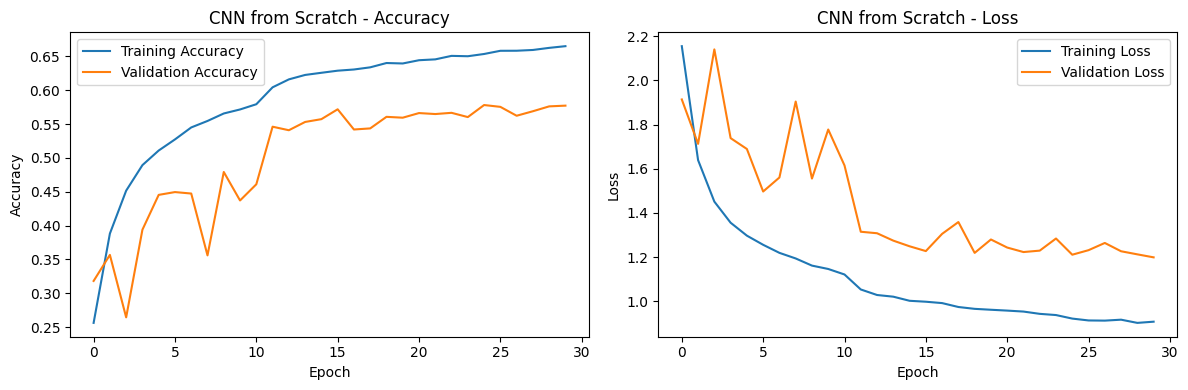

Training transfer_learning...
Epoch 1/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 410s 586ms/step - accuracy: 0.2061 - loss: 2.2858 - val_accuracy: 0.2728 - val_loss: 1.8529 - learning_rate: 1.0000e-04
Epoch 2/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 413s 593ms/step - accuracy: 0.2480 - loss: 2.0210 - val_accuracy: 0.3015 - val_loss: 1.7870 - learning_rate: 1.0000e-04
Epoch 3/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 402s 578ms/step - accuracy: 0.2712 - loss: 1.9093 - val_accuracy: 0.3102 - val_loss: 1.7737 - learning_rate: 1.0000e-04
Epoch 4/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 409s 588ms/step - accuracy: 0.2823 - loss: 1.8583 - val_accuracy: 0.3100 - val_loss: 1.7659 - learning_rate: 1.0000e-04
Epoch 5/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 406s 584ms/step - accuracy: 0.2962 - loss: 1.8281 - val_accuracy: 0.3118 - val_loss: 1.7649 - learning_rate: 1.0000e-04
Epoch 6/30
696/696 ━━━━━━━━━━━━━━━━━━━━ 401s 577ms/step - accuracy: 0.3069 - loss: 1.7830 - val_accuracy: 0.3287 - val_loss: 1.7457 - learning_rate: 1.0000e-04
Epoch 7/30

In [ ]:
# Cell 9: Train All Models (Optional - takes time)
# Uncomment to train all models
# Make sure data generators are created
if 'train_gen' not in locals():
    train_gen, val_gen = create_data_generators()

# Train CNN from scratch
cnn_history = train_model(cnn_model, train_gen, val_gen, 'cnn_scratch', 0.001)
plot_training_history(cnn_history, 'CNN from Scratch')

# Train Transfer Learning model
transfer_history = train_model(transfer_model, train_gen, val_gen, 'transfer_learning', 0.0001)
plot_training_history(transfer_history, 'Transfer Learning')

# Train Fine-Tuned model
fine_tuned_history = train_model(fine_tuned_model, train_gen, val_gen, 'fine_tuned', 0.0001)
plot_training_history(fine_tuned_history, 'Fine Tuned')


In [ ]:
# Cell 10: Model Comparison (if all models trained)
"""
# Compare model performances
models_comparison = {
    'CNN from Scratch': max(cnn_history.history['val_accuracy']),
    'Transfer Learning': max(transfer_history.history['val_accuracy']),
    'Fine Tuned': max(fine_tuned_history.history['val_accuracy'])
}

plt.figure(figsize=(10, 6))
plt.bar(models_comparison.keys(), models_comparison.values())
plt.title('Model Comparison - Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(models_comparison.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.show()

# Select best model
best_model_name = max(models_comparison, key=models_comparison.get)
print(f"Best model: {best_model_name} with accuracy: {models_comparison[best_model_name]:.4f}")
"""

In [ ]:
# Cell 11: Real-time Emotion Detection Class
class EmotionDetector:
    def __init__(self, model_path):
        self.model = keras.models.load_model(model_path)
        self.emotions = EMOTIONS
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    def preprocess_face(self, face_img):
        """Preprocess face image for model prediction"""
        face_img = cv2.resize(face_img, IMG_SIZE)
        face_img = face_img.astype('float32') / 255.0
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension
        
        # Check if model expects 1 or 3 channels
        if self.model.input_shape[-1] == 3:
            face_img = np.repeat(face_img, 3, axis=-1)
        
        return face_img
    
    def detect_emotion(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x, y, w, h) in faces:
            face_roi = gray[y:y+h, x:x+w]
            
            try:
                processed_face = self.preprocess_face(face_roi)
                prediction = self.model.predict(processed_face, verbose=0)
                emotion_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                
                # Draw rectangle and label
                color = (0, 255, 0) if confidence > 0.6 else (0, 165, 255) if confidence > 0.3 else (0, 0, 255)
                cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
                
                label = f"{self.emotions[emotion_idx]} ({confidence:.2f})"
                cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                
            except Exception as e:
                print(f"Error in emotion detection: {e}")
        
        return frame
    
    def run_camera(self):
        """Run real-time emotion detection using webcam"""
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("Error: Could not open camera")
            return
        
        print("Press 'q' to quit, 's' to save screenshot")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break
                
            frame = self.detect_emotion(frame)
            cv2.imshow('Emotion Detection - Press Q to quit', frame)
            
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                # Save screenshot
                cv2.imwrite('emotion_detection_screenshot.jpg', frame)
                print("Screenshot saved!")
        
        cap.release()
        cv2.destroyAllWindows()
    
    def test_on_image(self, image_path):
        """Test emotion detection on a single image"""
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not load image {image_path}")
            return
        
        result = self.detect_emotion(image)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title('Emotion Detection Result')
        plt.axis('off')
        plt.show()

In [ ]:
# Cell 12: Test with Pre-trained Model (Example)
# For demonstration, we'll create a simple test
# In practice, you would use your trained model

def demo_emotion_detection():
    """
    Demo function - replace with your actual trained model
    """
    print("Emotion Detection Demo")
    print("This is a demo. To use the actual model:")
    print("1. Train the models in previous cells")
    print("2. Load your trained model like: detector = EmotionDetector('your_model.h5')")
    print("3. Run: detector.run_camera()")
    
    # Example of how to use after training:
    # detector = EmotionDetector('fine_tuned_emotion.h5')
    # detector.run_camera()

demo_emotion_detection()

In [ ]:
# Cell 13: Quick Model Training (Simplified)
# If you want to quickly test one model

def train_quick_model():
    """
    Train a simplified model quickly for testing
    """
    if 'train_gen' not in locals():
        train_gen, val_gen = create_data_generators()
    
    # Simple model for quick training
    simple_model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    simple_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train for fewer epochs
    history = simple_model.fit(
        train_gen,
        epochs=5,  # Very few epochs for quick testing
        validation_data=val_gen,
        verbose=1
    )
    
    simple_model.save('quick_model.h5')
    print("Quick model trained and saved!")
    
    return simple_model, history


In [ ]:
# Uncomment to train quick model
quick_model, quick_history = train_quick_model()

In [ ]:
# Cell 14: Usage Example After Training

# After training, use like this:

# Load your best model
detector = EmotionDetector('fine_tuned_emotion.h5')  # or your best model

"""
# Test on webcam
detector.run_camera()
"""

# Or test on an image
detector.test_on_image('test_image.jpg')
